In [1]:
%matplotlib inline
from __future__ import division

import numpy as np
import pandas as pd
import json
import csv
import collections

import matplotlib.pyplot as plt
import seaborn as sns

import pysentiment as ps

# SK-learn libraries for learning.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Ensemble methods
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from scipy.stats import uniform

import pydot

In [2]:
# Load json dataset into pandas
train = pd.read_json('train.json', convert_dates=['unix_timestamp_of_request'])
test = pd.read_json('test.json', convert_dates=['unix_timestamp_of_request'])

In [3]:
# There are more columns in the train dataset than there are in the test dataset.  Remove the features
# that aren't available in the test dataset because we won't be able to use them in the model
def remove_train_features():
    data_cols = set(train.columns.values)
    test_cols = set(test.columns.values)
    trim_data_cols = data_cols.intersection(test_cols)
    return list(trim_data_cols)

trim_data_cols = remove_train_features()
trim_data_cols.append('requester_received_pizza') 
train = train[trim_data_cols]

In [4]:
import re
def get_word_counts(df, word_list):
    entry_count = []
    for entry in df.all_text:
        word_dict = dict((x,0) for x in word_list)
        for word in re.findall(r"\w+", entry):
            if word in word_dict:
                word_dict[word] += 1
        entry_count.append(sum(word_dict.values()))
    return pd.Series(entry_count)

In [18]:
# Topics and keywords from paper
job = ['work', 'paycheck', 'unemployment', 'interview', 'fired', 'unemployment', 'hire', 'hired']
money = ['money', 'now', 'broke', 'week', 'until', 'time', 'last', 'day', 'when', 'today', 'tonight', 'paid', 'next', 'first', 'night', 'after', 'tomorrow', 'month', 'while', 'account', 'before', 'long', 'friday', 'rent', 'buy', 'bank', 'still', 'bills', 'ago', 'cash', 'due', 'past', 'never', 'paycheck', 'check', 'spent', 'years', 'poor', 'till', 'yesterday', 'morning', 'dollars', 'financial', 'hour', 'bill', 'evening', 'credit', 'budget', 'loan', 'bucks', 'deposit', 'dollar', 'current', 'payed']
student = ['college', 'student', 'school', 'roommate', 'studying', 'semester', 'university', 'finals', 'study', 'class', 'project', 'dorm', 'tuition']
family = ['family', 'mom', 'wife', 'wifey', 'parents', 'mother', 'husband', 'dad', 'son', 'daughter', 'father', 'parent', 'mom', 'baby', 'born', 'newborn', 'kid', 'children', 'child']
craving = ['friend', 'girlfriend', 'craving', 'birthday', 'boyfriend', 'celebrate', 'party', 'game', 'games', 'movie', 'date', 'drunk', 'beer', 'celebrating', 'invited', 'drinks', 'crave', 'wasted', 'invite']
#reciprocity = ['forward', 'reciprocate', 'return', 'favor', 'repay']
gratitude = ['thank', 'thanks', 'blessed', 'bless', 'grateful']
military = ['veteran', 'army', 'navy', 'force', 'vet', 'seals', 'marine', 'va', 'veterans']

In [19]:
def get_sentiment(df):
    hiv4 = ps.HIV4()
    df['sentiment_polarity'] = map(lambda x: hiv4.get_score(hiv4.tokenize(x))['Polarity'], df['all_text'])
    df['sentiment_positive'] = map(lambda x: hiv4.get_score(hiv4.tokenize(x))['Positive'], df['all_text'])
    df['sentiment_negative'] = map(lambda x: hiv4.get_score(hiv4.tokenize(x))['Negative'], df['all_text'])
    df['sentimented_words'] = df['sentiment_positive'] + df['sentiment_negative']
    df['sentiment_ratio'] = df['sentiment_positive']/df['sentimented_words'].replace({ 0 : np.nan })
    df['sentiment_ratio'] = df['sentiment_ratio'].replace({np.nan : 0})
    return df

In [20]:
def get_pos_train_text(orig_df, top_k=10):
    df = orig_df.copy()
    df['all_text'] = [df.request_title.iloc[[i]].tolist()[0] + ' ' + df.request_text_edit_aware.iloc[[i]].tolist()[0]
                    for i in range(df.shape[0])]
    pos_post_text = [df.all_text[i] for i in range(df.shape[1]) if df.requester_received_pizza[i] == 1]
    neg_post_text = [df.all_text[i] for i in range(df.shape[1]) if df.requester_received_pizza[i] == 0]
    cv = CountVectorizer(stop_words='english', max_features=top_k)
    cv.fit_transform(pos_post_text)
    pos_words = collections.OrderedDict(sorted(cv.vocabulary_.items()))
    
    cv_neg = CountVectorizer(stop_words='english', max_features=top_k)
    cv_neg.fit_transform(neg_post_text)
    neg_words = collections.OrderedDict(sorted(cv_neg.vocabulary_.items()))
    
    pos_words = set(pos_words.keys())
    neg_words = set(neg_words.keys())

    neg_dict = [i for i in neg_words if i not in pos_words]
    pos_dict = [i for i in pos_words if i not in neg_words]
    return pos_dict

pos_words = get_pos_train_text(train, 30)

In [21]:
# actual search for reciprocity - seems to be coming up on error analysis
def reciprocity_search(df):
    reciprocate = []
    all_text = df.all_text.values
    comps = [re.compile(r'return.+favor'), re.compile(r'pay.+forward'), re.compile(r'pay.+back'),
             re.compile(r'give.+back'), re.compile(r'repay'), re.compile(r'reciprocate'), re.compile(r'participate')]

    for entry in range(len(all_text)):
        contains_words = 0
        for comp in comps:
            if len(re.findall(comp, all_text[entry])) > 0:
                contains_words = 1
        reciprocate.append(contains_words)
    return reciprocate

In [22]:
# Feature creation
def encode_features(df, fte):
    '''create dummy variables for categorical data'''
    for feature in fte:
        df = df.join(pd.get_dummies(df[feature], prefix=feature))
    return df

def preprocess(df):
    df['karma_cat_2'] = np.where(df.requester_upvotes_minus_downvotes_at_request <= 10, 0, 1)
    df['all_text'] = [df.request_title.iloc[[i]].tolist()[0] + ' ' + df.request_text_edit_aware.iloc[[i]].tolist()[0]
                    for i in range(df.shape[0])]
    df['job_c'] = get_word_counts(df, job)
    df['money_c'] = get_word_counts(df, money)
    df['student_c'] = get_word_counts(df, student)
    df['family_c'] = get_word_counts(df, family)
    df['craving_c'] = get_word_counts(df, craving)
    df['gratitude_c'] = get_word_counts(df, gratitude)
    df['military_c'] = get_word_counts(df, military)
    df['exclamation_c'] = map(lambda x: len(re.findall(r'(!)|(:\))', x)), df['all_text'])
    df['post_length'] = df['request_text_edit_aware'].map(lambda x: len(x))
    df['request_title_length'] = df['request_title'].map(lambda x: len(x))
    df['pos_words'] = get_word_counts(df, pos_words)
    df['link'] = map(lambda x: 1 if x.find('http') > 0 else 0, df['request_text_edit_aware'])
    df['img'] = map(lambda x: 1 if x.find('img') > 0 else 0, df['request_text_edit_aware'])
    df['weekday'] = map(lambda x: x.weekday(), df['unix_timestamp_of_request'])
    df['month'] = map(lambda x: x.month, df['unix_timestamp_of_request'])
    df['hour'] = map(lambda x: x.hour, df['unix_timestamp_of_request'])
    df['afternoon'] = map(lambda x: 1 if (x >= 13 and x <= 19) else 0, df['hour'])
    
    reciprocate = reciprocity_search(df)
    df['reciprocate_c'] = reciprocate
    
    # binary var if new account
    df['newacct'] = map(lambda x: 1 if x > 0 else 0, df['requester_account_age_in_days_at_request'])
    df['military_bin'] = map(lambda x: 1 if x > 0 else 0, df['military_c'])
    df['gratitude_bin'] = map(lambda x: 1 if x > 0 else 0, df['gratitude_c'])
    

    # MA -> REMOVE LATER
    df['evening'] = map(lambda x: 1 if (x >= 19 and x <= 23) else 0, df['hour'])
    df['dayct'] = map(lambda x: x.day, df['unix_timestamp_of_request'])
    df['firsthalf'] = map(lambda x: 1 if (x <= 15 ) else 0, df['dayct'])
    
    t1 = df['requester_account_age_in_days_at_request']
    t2 = df['requester_number_of_comments_at_request']
    t3 = df['requester_number_of_posts_at_request']
    t4 = df['requester_number_of_subreddits_at_request']

    t5 = df['requester_number_of_comments_in_raop_at_request']
    t6 = df['requester_number_of_posts_on_raop_at_request']
    t7 = df['requester_days_since_first_post_on_raop_at_request']

    t8 = df['requester_upvotes_minus_downvotes_at_request']
    t9 = df['requester_upvotes_plus_downvotes_at_request']

    t_novotes = np.zeros(len(t1))
    t_inactive = np.zeros(len(t1))
    t_inact_raop = np.zeros(len(t1))

    for i in range(len(t1)):
        if t2[i] == 0 and t3[i] == 0 and t4[i] == 0:
            t_inactive[i] = 1
        t0 = int(t7[i])    
        if t5[i] == 0 and t6[i] == 0 and t0 == 0:
            t_inact_raop[i] = 1
        if t8[i] == 0 and t9[i] == 0:
            t_novotes[i] = 1
    
    df['inactive'] = t_inactive
    df['inact_raop'] = t_inact_raop
    df['novotes'] = t_novotes

    df['link_or_img'] = map(lambda x: 1 if x.find('img') > 0 or x.find('http') > 0 else 0, df['request_text_edit_aware'])
    df['time_c'] = map(lambda x: 1 if x >= 1342561000 else 0, df['unix_timestamp_of_request_utc'])

    features_to_encode = ['weekday', 'hour', 'month']
    encode_features(df, features_to_encode)
    '''
    get_sentiment(df)
    df['sentiment_ratio_bin'] = map(lambda x: 1 if x > .5 else 0, df['sentiment_ratio'])
    df['sentiment_polarity_bin'] = map(lambda x: 1 if x > 0 else 0, df['sentiment_polarity'])
    '''
    return df

In [23]:
train_preprocess = preprocess(train)
test_preprocess = preprocess(test)

requester_received_pizza  False  True 
afternoon                             
0                          2359    711
1                           687    283


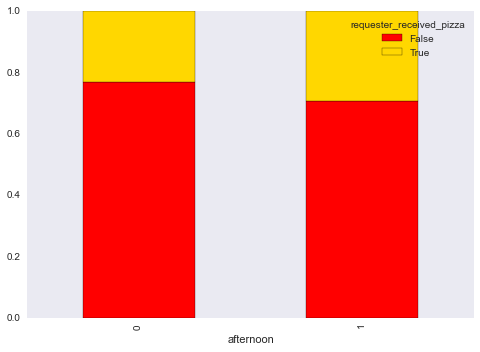

In [35]:
def get_dist(cat, labels):
    '''graphs crosstable for different variables with graph by % outcome'''
    crosstab = pd.crosstab(cat, labels)
    print(crosstab)
    crosstab.div(crosstab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True, color=['red','gold'], grid=False)
    
get_dist(train_preprocess.afternoon, train_preprocess.requester_received_pizza)

In [132]:
features = ['karma_cat_2', 'afternoon', 'img', 'gratitude_c',
                   'post_length', 'requester_number_of_posts_on_raop_at_request',
                   'job_c', 'money_c', 'family_c', 'student_c', 'craving_c', 'request_title_length',
                   'requester_number_of_comments_in_raop_at_request', 'time_c', 'reciprocate_c']


features = ['karma_cat_2', 'afternoon', 'img', 'gratitude_c','requester_number_of_posts_on_raop_at_request',
            'money_c', 'family_c', 'craving_c','requester_number_of_comments_in_raop_at_request', 'time_c',
            'newacct', 'firsthalf', 'reciprocate_c', 'request_title_length'
           ]

train_pre = preprocess(train)
test_pre = preprocess(test)

train_pre = train_pre[features]
test_pre = test_pre[features]

scaler = scalar = preprocessing.StandardScaler()
scaler.fit(train_pre.values)

train_sc = scalar.transform(train_pre.values)

np.random.seed(0)
shuffle = np.random.permutation(np.arange(train.shape[0]))

# Pull out text features
train_length = 3230
data_mat, labels = train_sc[shuffle], train.requester_received_pizza.values[shuffle]

# shuffle training data for error analysis
data_shuffle = pd.DataFrame(train, index=shuffle)

train_data, train_labels = data_mat[:train_length], labels[:train_length]
dev_data, dev_labels = data_mat[train_length:], labels[train_length:]

test_data = scalar.transform(test_pre.values)

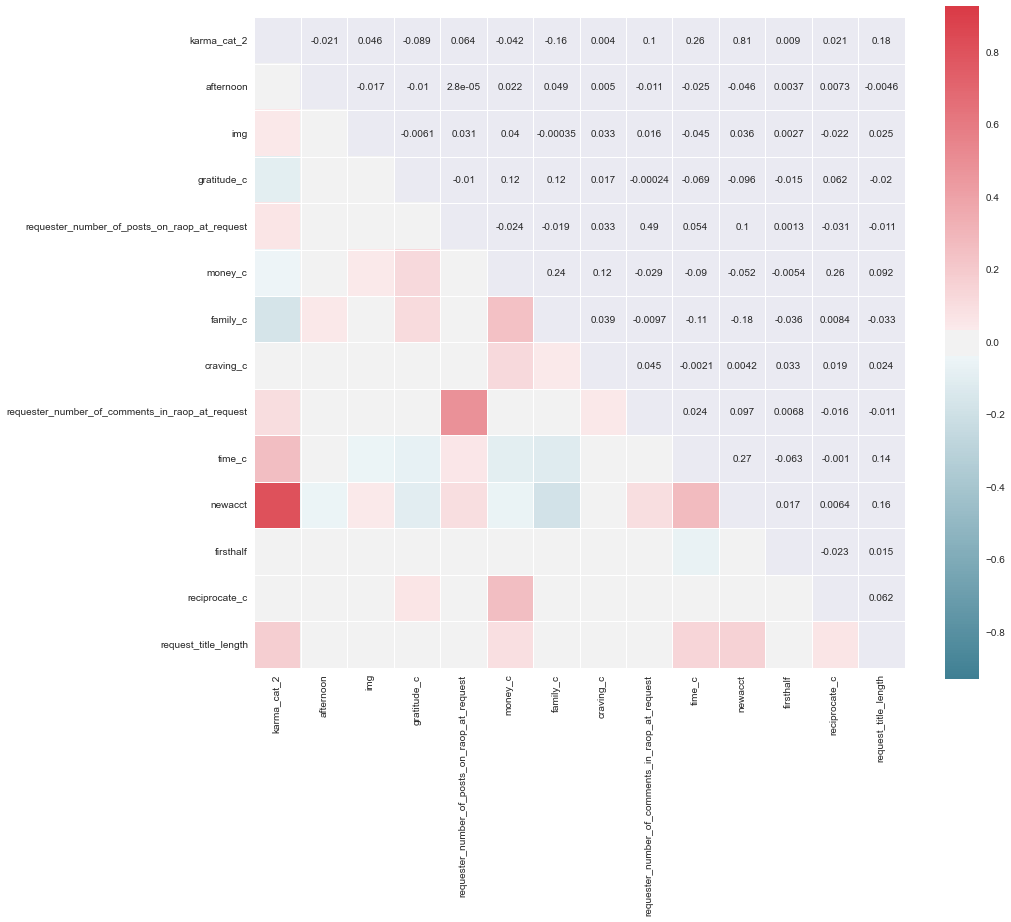

In [133]:
# Correlation heatmap all features 
def correlation_heatmap():
    fig, ax = plt.subplots(figsize=(15, 15), dpi=80)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.corrplot(train_data, names=features, annot=True, sig_stars=False,
                 diag_names=False, cmap=cmap, ax=ax)
    fig.tight_layout()
    

correlation_heatmap()

In [134]:
def ada_boost():
    
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=290)
    scores = cross_val_score(clf, train_data, train_labels)
    print scores
    clf.fit(train_data, train_labels)
    pred = clf.predict(dev_data)
    print clf.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)
    print clf.feature_importances_ 

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    return clf

    
ada = ada_boost()

[ 0.75208914  0.76508821  0.75      ]
0.761728395062
             precision    recall  f1-score   support

      False       0.96      0.78      0.86       751
       True       0.17      0.58      0.26        59

avg / total       0.90      0.76      0.81       810

[ 0.00689655  0.00344828  0.00344828  0.00689655  0.01034483  0.1137931
  0.03448276  0.03448276  0.09310345  0.00689655  0.00344828  0.00689655
  0.00344828  0.67241379]
[[583  25]
 [168  34]]


In [135]:
def get_svc():
    svc_params = {"kernel": ['linear', 'rbf'], "probability": [False, True] }
    svc = GridSearchCV(SVC(), svc_params)
    svc.fit(train_data, train_labels)
    preds = svc.predict(dev_data)
    print svc.score(dev_data, dev_labels)
    print classification_report(preds, dev_labels)
    print svc.best_params_ 
    return svc


svc = get_svc()

0.753086419753
             precision    recall  f1-score   support

      False       0.99      0.76      0.86       798
       True       0.03      0.58      0.07        12

avg / total       0.98      0.75      0.85       810

{'kernel': 'linear', 'probability': False}


In [136]:
def log_reg():
    param_grid = [{'C': np.arange(.1, 1, .1), 'penalty': ['l1', 'l2']}]
    logreg = LogisticRegression()
    logreg = GridSearchCV(logreg, param_grid)
    logreg.fit(train_data, train_labels)
    print("Best C: {}, with and accuracy of: {}".format(logreg.best_params_, logreg.best_score_))
    pred = logreg.predict(dev_data)
    print logreg.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)
    print logreg.best_estimator_.coef_
    return logreg
    

logreg = log_reg()

Best C: {'penalty': 'l1', 'C': 0.20000000000000001}, with and accuracy of: 0.760371517028
0.759259259259
             precision    recall  f1-score   support

      False       0.98      0.77      0.86       779
       True       0.09      0.61      0.16        31

avg / total       0.95      0.76      0.83       810

[[ 0.14740262  0.15107278  0.11110271  0.07199807  0.24322898  0.28892554
   0.0619454  -0.09514632  0.21496882 -0.28683618  0.21719578  0.07805428
   0.10769692  0.00117332]]


In [137]:
def gradient_boost():
    
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.15, n_estimators=20, 
        min_samples_split=2,subsample=0.3, min_samples_leaf=1,
        max_depth=3, init=None, random_state=None, max_features=None,verbose=False)
    scores = cross_val_score(clf, train_data, train_labels)
    print scores
    clf.fit(train_data, train_labels)
    pred = clf.predict(dev_data)
    print clf.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)

    cm = confusion_matrix(dev_labels, pred)
    #print(cm)
    
    for i in range(len(pred)):
        if pred[i] == 0 and dev_labels[i] == 1:
            #print data_shuffle.all_text.iloc[[i]].tolist()[0]
            pass
    return clf

grad = gradient_boost()

[ 0.76044568  0.76230269  0.75092937]
0.754320987654
             precision    recall  f1-score   support

      False       0.97      0.76      0.86       775
       True       0.09      0.54      0.16        35

avg / total       0.94      0.75      0.83       810



In [139]:
def weighted_model(data):
    ada_pred = map(lambda x: 1. if x == True else 0., ada.predict(data))
    #ada_proba = ada.predict_proba(data)
    svc_pred = map(lambda x: 1. if x == True else 0., svc.best_estimator_.predict(data))
    grad_pred = map(lambda x: 1. if x == True else 0., grad.predict(data))
    logreg_pred = map(lambda x: 1. if x == True else 0., logreg.best_estimator_.predict(data))
    #logreg_proba_ = logreg.best_estimator_.predict_proba(data)

    final_preds = []
    print data.shape
    for i in range(data.shape[0]):
        w = ada_pred[i] + grad_pred[i] + logreg_pred[i]
        w_pred = 1.0 * w / 3
        if w_pred >= .1:
            final_preds.append(1)
        else:
            final_preds.append(0)
    
    return final_preds

def get_accuracy(final_preds):
    correct = 0
    total = 0
    for j in range(len(final_preds)):
        if final_preds[j] == dev_labels[j]:
            correct += 1
        total += 1
    print 1.0 * correct / total 
        #print("Predict 1, but actually 0")
        #print svc.best_estimator_.predict_proba(dev_data)[i]
        #print ada.predict_proba(dev_data)[i]
        #print logreg.best_estimator_.predict_proba(dev_data)[i]

#print ada_proba[:,1]
#adj_preds = map(lambda x: 1 if x >= .5 else 0, svc_proba[:,1])
final_preds = weighted_model(dev_data)
print classification_report(final_preds, dev_labels)
get_accuracy(final_preds)

(810, 14)
             precision    recall  f1-score   support

          0       0.98      0.77      0.86       778
          1       0.10      0.66      0.18        32

avg / total       0.95      0.76      0.83       810

0.762962962963


In [98]:
test_preds = weighted_model(test_data)
request_ids = test['request_id'].values

(1631, 13)


In [99]:
with open('submission.csv', 'wb') as csvfile:
    outputwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    outputwriter.writerow(['request_id'] + ['requester_received_pizza'])
    
    for i in range(len(request_ids)):
        outputwriter.writerow([request_ids[i], str(test_preds[i])])

In [103]:
# Error analysis
def get_top_misses(preds, probas, n=3):
    max_misses = np.zeros(n)
    max_misses_idx = np.zeros(n)
    for i in range(len(preds)):
        if preds[i] != dev_labels[i]:
            prob = max(probas[i])
            if np.amin(max_misses) < prob:
                idx = np.argmin(max_misses)
                max_misses[idx] = prob
                max_misses_idx[idx] = i
    return max_misses_idx
    

def error_analysis():
    ada_pred = ada.predict(dev_data)
    ada_proba = ada.predict_proba(dev_data)
    logreg_pred = logreg.predict(dev_data)
    logreg_proba = logreg.best_estimator_.predict_proba(dev_data)
    ada_top_misses = get_top_misses(logreg_pred, logreg_proba, 5)

    for i in ada_top_misses:
        print "Correct Label: %s" % dev_labels[i]
        print data_shuffle.all_text.iloc[[i+train_length]].tolist()[0] 
        print ""
error_analysis()    
    

Correct Label: True
[Request] Just woke up, I could really use some pizza My buddy told me about this sub-reddit just a moment ago and I thought it was silly. I guess I'll post a request but if nobody replies that's great too. (I hope there aren't any rules that I'm missing if I did please let me know.)

Correct Label: True
[request] girlfriend and i have the house alone tonight, would love a pizza to celebrate! Our roommates are all out of town, and a pizza to snack on during our movie night would be great. Thanks guys!

EDIT: We're in Portland, OR.

Correct Label: True
[request] Pennsylvnia USA Would love to have pizza night for me and my daughter its just me and my 9 year old daughter tonight.we plan on watching christmas movies.she got real good grades on her report card and would like to suprise her with a pizza.thanks

Correct Label: True
[Request] First date with the girl of my dreams WARNING: TL;DR


Hey, so after 4 years of knowing this person, I've finally asked out the woman